In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [99]:
import abc
import math
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns

c:\Users\miaoz\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\miaoz\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\miaoz\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\miaoz\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

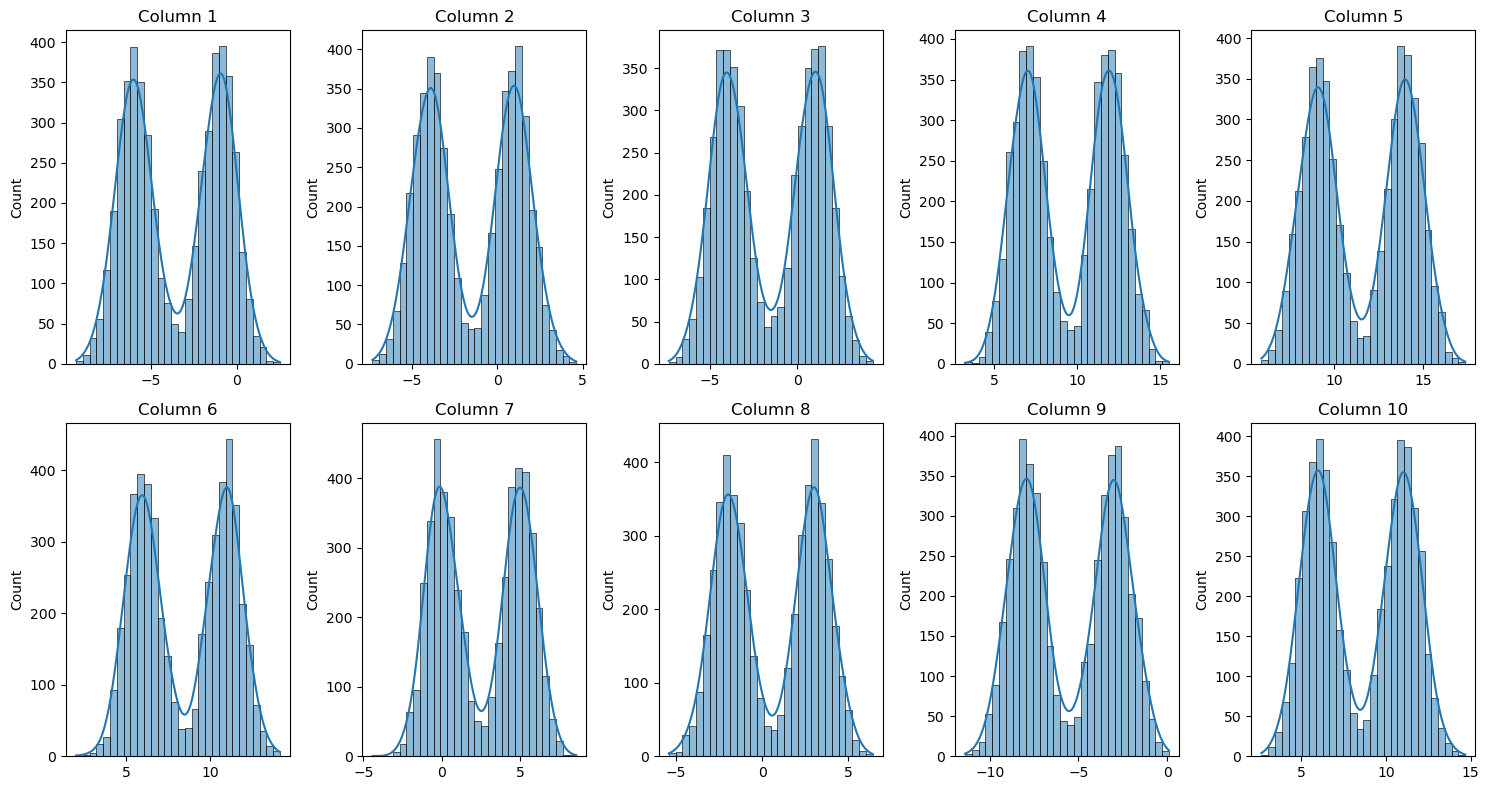

In [100]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

data_size = 5000
np.random.seed(64)

# Generate a random integer array 'a' with shape (10, 1)
a = np.random.randint(-10, 10, size=(10, 1))

# Flatten 'a' to create the mean vector for the multivariate normal distribution
mean = a.flatten()

# Generate two sets of multivariate normal data 'b1' and 'b2' with shape (data_size, 10)
b1 = np.random.multivariate_normal(mean=mean, cov=np.eye(10), size=data_size // 2)
b2 = np.random.multivariate_normal(mean=mean + 5, cov=np.eye(10), size=data_size // 2)

# Concatenate 'b1' and 'b2' to create a bimodal distribution
b = np.vstack((b1, b2))

# Create a 2x5 grid of subplots
fig, axes = plt.subplots(2, 5, figsize=(15, 8))

# Flatten the 2x5 axes array for easy iteration
axes = axes.flatten()

# Loop through each column of 'b' and plot its histogram on the corresponding subplot
for i in range(10):
    sns.histplot(b[:, i], kde=True, bins=30, ax=axes[i])
    axes[i].set_title(f'Column {i+1}')  # Set the title for each subplot

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


In [101]:
class Backbone(nn.Module):
    def __init__(self, n_steps, input_dim = 2):
        super().__init__()
        self.linear_model1 = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.Dropout(0.2),
            nn.GELU()
        )
        # Condition time t
        self.embedding_layer = nn.Embedding(n_steps, 256)
        
        self.linear_model2 = nn.Sequential(
            nn.Linear(256, 512),
            nn.Dropout(0.2),
            nn.GELU(),
            
            nn.Linear(512, 512),
            nn.Dropout(0.2),
            nn.GELU(),
            
            nn.Linear(512, input_dim),
        )
    def forward(self, x, idx):        
        x = self.linear_model2(self.linear_model1(x) + self.embedding_layer(idx))
        return x


In [102]:
import torch
import torch.nn as nn
def build_score_network(input_dim=2, hidden_dim=128, num_layers=2):

    layers = []
    
    # 添加第一层
    layers.append(nn.Linear(input_dim, hidden_dim))
    layers.append(nn.Softplus())
    
    # 添加中间隐藏层
    for _ in range(num_layers - 1):
        layers.append(nn.Linear(hidden_dim, hidden_dim))
        layers.append(nn.Softplus())
    
    # 添加输出层
    layers.append(nn.Linear(hidden_dim, input_dim))
    
    # 构建模型
    model = nn.Sequential(*layers)
    
    return model

In [103]:
class Model(nn.Module):
    def __init__(self, device, beta_1, beta_T, T, input_dim):
        '''
        The epsilon predictor of diffusion process.

        beta_1    : beta_1 of diffusion process
        beta_T    : beta_T of diffusion process
        T         : Diffusion Steps
        input_dim : a dimension of data

        '''
        super().__init__()
        self.device = device
        self.alpha_bars = torch.cumprod(1 - torch.linspace(start = beta_1, end=beta_T, steps=T), dim = 0).to(device = device)
        self.backbone = Backbone(T, input_dim)
        
        self.to(device = self.device)

    def loss_fn(self, x, idx=None):
        '''
        This function performed when only training phase.

        x          : real data if idx==None else perturbation data
        idx        : if None (training phase), we perturbed random index. Else (inference phase), it is recommended that you specify.

        '''
        output, epsilon, alpha_bar = self.forward(x, idx=idx, get_target=True)
        loss = (output - epsilon).square().mean()
        return loss

    def forward(self, x, idx=None, get_target=False):
        '''
        x          : real data if idx==None else perturbation data
        idx        : if None (training phase), we perturbed random index. Else (inference phase), it is recommended that you specify.
        get_target : if True (training phase), target and sigma is returned with output (epsilon prediction)

        '''

        if idx == None:
            idx = torch.randint(0, len(self.alpha_bars), (x.size(0), )).to(device = self.device)
            used_alpha_bars = self.alpha_bars[idx][:, None]
            epsilon = torch.randn_like(x)
            x_tilde = torch.sqrt(used_alpha_bars) * x + torch.sqrt(1 - used_alpha_bars) * epsilon
        else:
            idx = torch.Tensor([idx for _ in range(x.size(0))]).to(device = self.device).long()
            x_tilde = x
            

            
        output = self.backbone(x_tilde, idx)
        
        return (output, epsilon, used_alpha_bars) if get_target else output

In [104]:
class DiffusionProcess():
    def __init__(self, beta_1, beta_T, T, diffusion_fn, device, datadim):
        '''
        beta_1        : beta_1 of diffusion process
        beta_T        : beta_T of diffusion process
        T             : step of diffusion process
        diffusion_fn  : trained diffusion network
        datadim         : data dimension
        '''

        self.betas = torch.linspace(start = beta_1, end=beta_T, steps=T)
        self.alphas = 1 - self.betas
        self.alpha_bars = torch.cumprod(1 - torch.linspace(start = beta_1, end=beta_T, steps=T), dim = 0).to(device = device)
        self.alpha_prev_bars = torch.cat([torch.Tensor([1]).to(device=device), self.alpha_bars[:-1]])
        self.datadim = datadim
        
        self.diffusion_fn = diffusion_fn
        self.device = device

    
    def _one_diffusion_step(self, x):
        '''
        x   : perturbated data
        '''
        eps = 0.01
        """
        prediction
        """
        for idx in reversed(range(len(self.alpha_bars))):
            noise = torch.zeros_like(x) if idx == 0 else torch.randn_like(x)
            sqrt_tilde_beta = torch.sqrt(self.betas[idx])
            predict_epsilon = self.diffusion_fn(x, idx)
            mu_theta_xt = torch.sqrt(1 / self.alphas[idx]) * (x + self.betas[idx] /2* predict_epsilon) 
            x = mu_theta_xt + sqrt_tilde_beta * noise
            x_sequence = [x.unsqueeze(0)]
            '''
            "correction"
            '''
            for s in range(10):
                x = x + eps * self.diffusion_fn(x,idx)+np.sqrt(2*eps)*torch.randn_like(x)
                x_sequence.append(x.unsqueeze(0))
            x = torch.cat(x_sequence)[-1,:]
            yield x
    
    @torch.no_grad()
    def sampling(self, sampling_number, only_final=False):
        '''
        sampling_number : a number of generation
        only_final      : If True, return is an only output of final schedule step 
        '''
        sample = torch.randn([sampling_number,self.datadim]).to(device = self.device).squeeze()
        sampling_list = []
        
        final = None
        for idx, sample in enumerate(self._one_diffusion_step(sample)):
            final = sample
            if not only_final:
                sampling_list.append(final)

        return final if only_final else torch.stack(sampling_list)

In [105]:
import torch.autograd as autograd
def sliced_score_matching(model, samples):
    samples.requires_grad_(True)
    # Construct random vectors
    vectors = torch.randn_like(samples)
    vectors = vectors / torch.norm(vectors, dim=-1, keepdim=True)
    # Compute the optimized vector-product jacobian
    logp, jvp = autograd.functional.jvp(model, samples, vectors, create_graph=True)
    # Compute the norm loss
    norm_loss = (logp * vectors) ** 2 / 2.
    # Compute the Jacobian loss
    v_jvp = jvp * vectors
    jacob_loss = v_jvp
    loss = jacob_loss + norm_loss
    return loss.mean(-1).mean(-1)

In [106]:
def train_ddpm(model,optimizer,num_epochs,traindata_loader,valdata_loader,early_stopping):
    best_loss = float('inf')
    early_stopping_counter = 0
    for epoch in range(num_epochs):
        whole_loss = 0
        for i, batch in enumerate(traindata_loader):
            batch_size = batch.shape[0]
            batch = batch.cuda()
            loss = sliced_score_matching(model,batch)
            whole_loss+=loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        val_loss = 0
        with torch.no_grad():
            for val_batch in valdata_loader:
                batch = val_batch.cuda()
                val_loss+= sliced_score_matching(model,batch)
            val_loss /= len(valdata_loader)
        if (epoch) % 20 == 0:
            print('epoch: {}, Train Loss: {:.4f}, Val Loss: {:.4f}'.format(epoch, whole_loss/len(traindata_loader), val_loss.item()))
        loss_new = val_loss
        if loss_new < best_loss:
            best_loss = loss_new
            early_stopping_counter = 0
            print('epoch: {}, find new best loss: Train Loss: {:.4f}'.format(epoch,best_loss))
            print('-' * 10)
        else:
            early_stopping_counter += 1
        if early_stopping_counter == early_stopping:
            print("Early stopping after {} epochs".format(epoch))
            break
    

In [107]:
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

batch_size = 64

# Split the data into training, validation, and test sets
X_train_5, X_temp_5 = train_test_split(b, test_size=0.4, random_state=42)
X_val_5, X_test_5 = train_test_split(X_temp_5, test_size=0.5, random_state=42)

# Convert to float32
X_train_5 = np.array(X_train_5, dtype=np.float32)
X_val_5 = np.array(X_val_5, dtype=np.float32)
X_test_5 = np.array(X_test_5, dtype=np.float32)

# Standardize the data
sc = StandardScaler()
sca_X_train_5 = sc.fit_transform(X_train_5)
sca_X_val_5 = sc.transform(X_val_5)
sca_X_test_5 = sc.transform(X_test_5)

# Create DataLoaders
sca_traindata_loader_5 = DataLoader(sca_X_train_5, batch_size=batch_size, shuffle=True)
sca_valdata_loader_5 = DataLoader(sca_X_val_5, batch_size=batch_size, shuffle=True)
sca_test_loader_5 = DataLoader(sca_X_test_5, batch_size=batch_size, shuffle=True)

In [108]:
batch_size =64
beta_1 = 1e-4
beta_T = 0.01
T = 100
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")
model = Model(device, beta_1, beta_T, T, X_train_5.shape[1])
optim = torch.optim.Adam(model.parameters(), lr = 0.001)
process = DiffusionProcess(beta_1, beta_T, T, model, device, X_train_5.shape[1])
train_ddpm(model,optim,500,sca_traindata_loader_5,sca_valdata_loader_5,100)

epoch: 0, Train Loss: -0.0536, Val Loss: -0.0850
epoch: 0, find new best loss: Train Loss: -0.0850
----------
epoch: 1, find new best loss: Train Loss: -0.1117
----------
epoch: 2, find new best loss: Train Loss: -0.1209
----------
epoch: 3, find new best loss: Train Loss: -0.1268
----------
epoch: 4, find new best loss: Train Loss: -0.1283
----------
epoch: 5, find new best loss: Train Loss: -0.1458
----------
epoch: 17, find new best loss: Train Loss: -0.1480
----------
epoch: 18, find new best loss: Train Loss: -0.1485
----------
epoch: 19, find new best loss: Train Loss: -0.1549
----------
epoch: 20, Train Loss: -0.1441, Val Loss: -0.1441
epoch: 29, find new best loss: Train Loss: -0.1551
----------
epoch: 30, find new best loss: Train Loss: -0.1590
----------
epoch: 35, find new best loss: Train Loss: -0.1652
----------
epoch: 40, Train Loss: -0.1501, Val Loss: -0.1457
epoch: 60, Train Loss: -0.1542, Val Loss: -0.1456
epoch: 68, find new best loss: Train Loss: -0.1667
----------
e

c:\Users\miaoz\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\miaoz\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\miaoz\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\miaoz\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

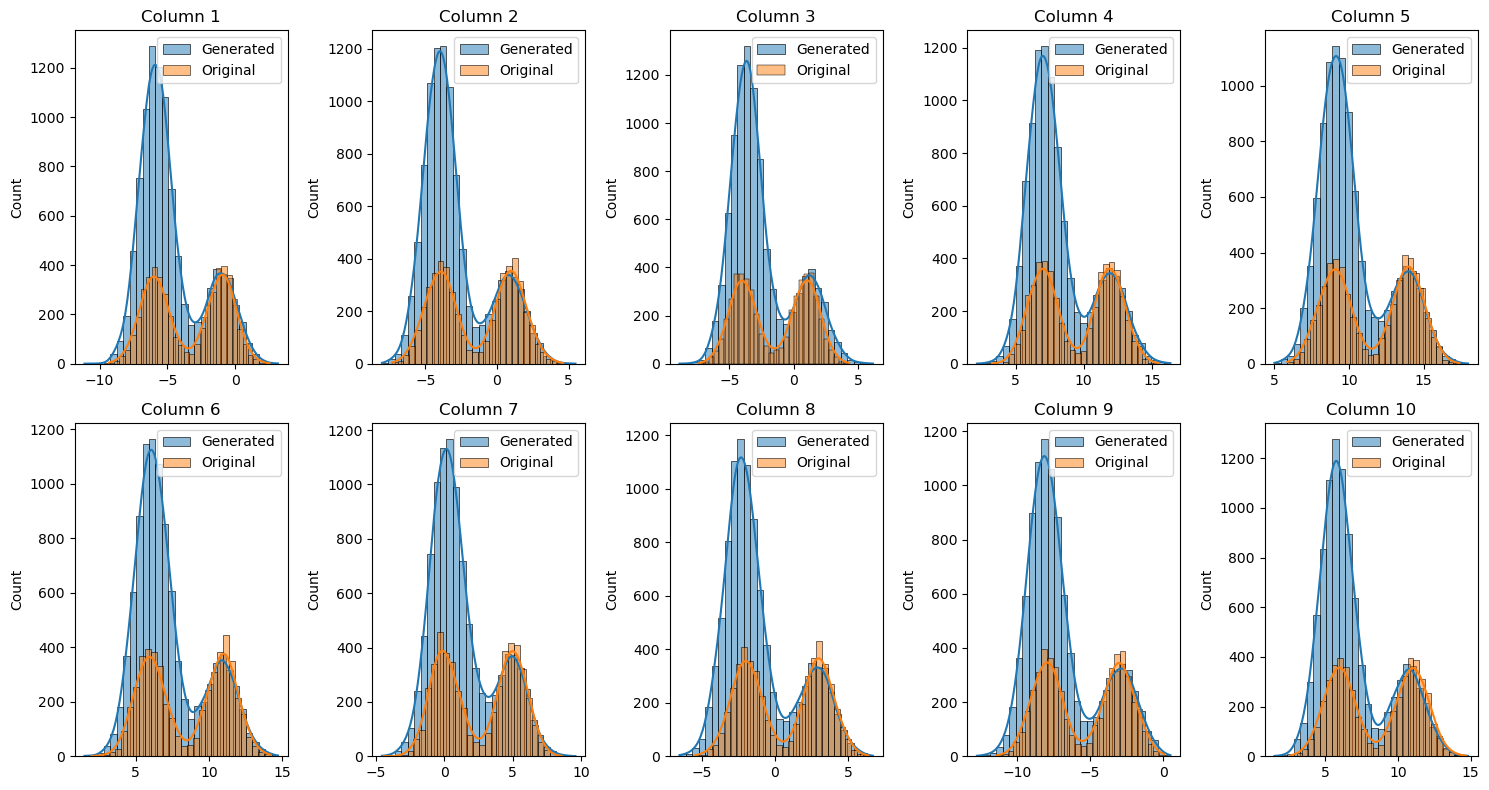

In [110]:
sampling_number = 10000
only_final = True
sample = process.sampling(sampling_number, only_final)
sample = sc.inverse_transform(sample.cpu().detach().numpy())
fig, axes = plt.subplots(2, 5, figsize=(15, 8))
axes = axes.flatten()

for i in range(10):
    sns.histplot(sample[:, i], kde=True, bins=30, ax=axes[i], label='Generated')
    sns.histplot(b[:, i], kde=True, bins=30, ax=axes[i], label='Original')
    axes[i].set_title(f'Column {i+1}')
    axes[i].legend()  # 添加图例

plt.tight_layout()

# Show the plot
plt.show()
